In [1]:
%load_ext autoreload
%autoreload 2

import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from lightning import seed_everything

from htc.cpp import map_label_image
from htc.fonts.set_font import set_font
from htc.model_processing.SinglePredictor import SinglePredictor
from htc.models.image.DatasetImage import DatasetImage
from htc.settings import settings
from htc.settings_seg import settings_seg
from htc.tivita.DataPath import DataPath
from htc_projects.rat.settings_rat import settings_rat
from htc_projects.species.settings_species import settings_species
from htc_projects.species.species_evaluation import load_nested_table

set_font(font_family="sans")

Seed set to 42


[INFO][htc.no_duplicates] Found pretrained run in the local results dir at                               HTCModel.py:626
/mnt/ssd_8tb/htc/results_species/training/image/2025-06-07_20-24-33_baseline_human_nested-0-2                           

[INFO][htc.no_duplicates] Found pretrained run in the local results dir at                               HTCModel.py:626
/mnt/ssd_8tb/htc/results_species/training/image/2025-06-07_20-24-33_baseline_human_nested-1-2                           

[INFO][htc.no_duplicates] Found pretrained run in the local results dir at                               HTCModel.py:626
/mnt/ssd_8tb/htc/results_species/training/image/2025-06-07_20-24-33_baseline_human_nested-2-2                           

[INFO][htc.no_duplicates] Found pretrained run in the local results dir at                               HTCModel.py:626
/mnt/ssd_8tb/htc/results_species/training/image/2025-06-07_20-24-33_projected-malperfusion_pig2human_nes                
ted-0-2                                                                                                                 

[INFO][htc.no_duplicates] Found pretrained run in the local results dir at                               HTCModel.py:626
/mnt/ssd_8tb/htc/results_species/training/image/2025-06-07_20-24-33_projected-malperfusion_pig2human_nes                
ted-1-2                                                                                                                 

[INFO][htc.no_duplicates] Found pretrained run in the local results dir at                               HTCModel.py:626
/mnt/ssd_8tb/htc/results_species/training/image/2025-06-07_20-24-33_projected-malperfusion_pig2human_nes                
ted-2-2                                                                                                                 

13    SPACE_000005#2020_08_19_15_20_43
Name: image_name, dtype: object
690    SPACE_000180#2021_04_27_14_54_12
Name: image_name, dtype: object


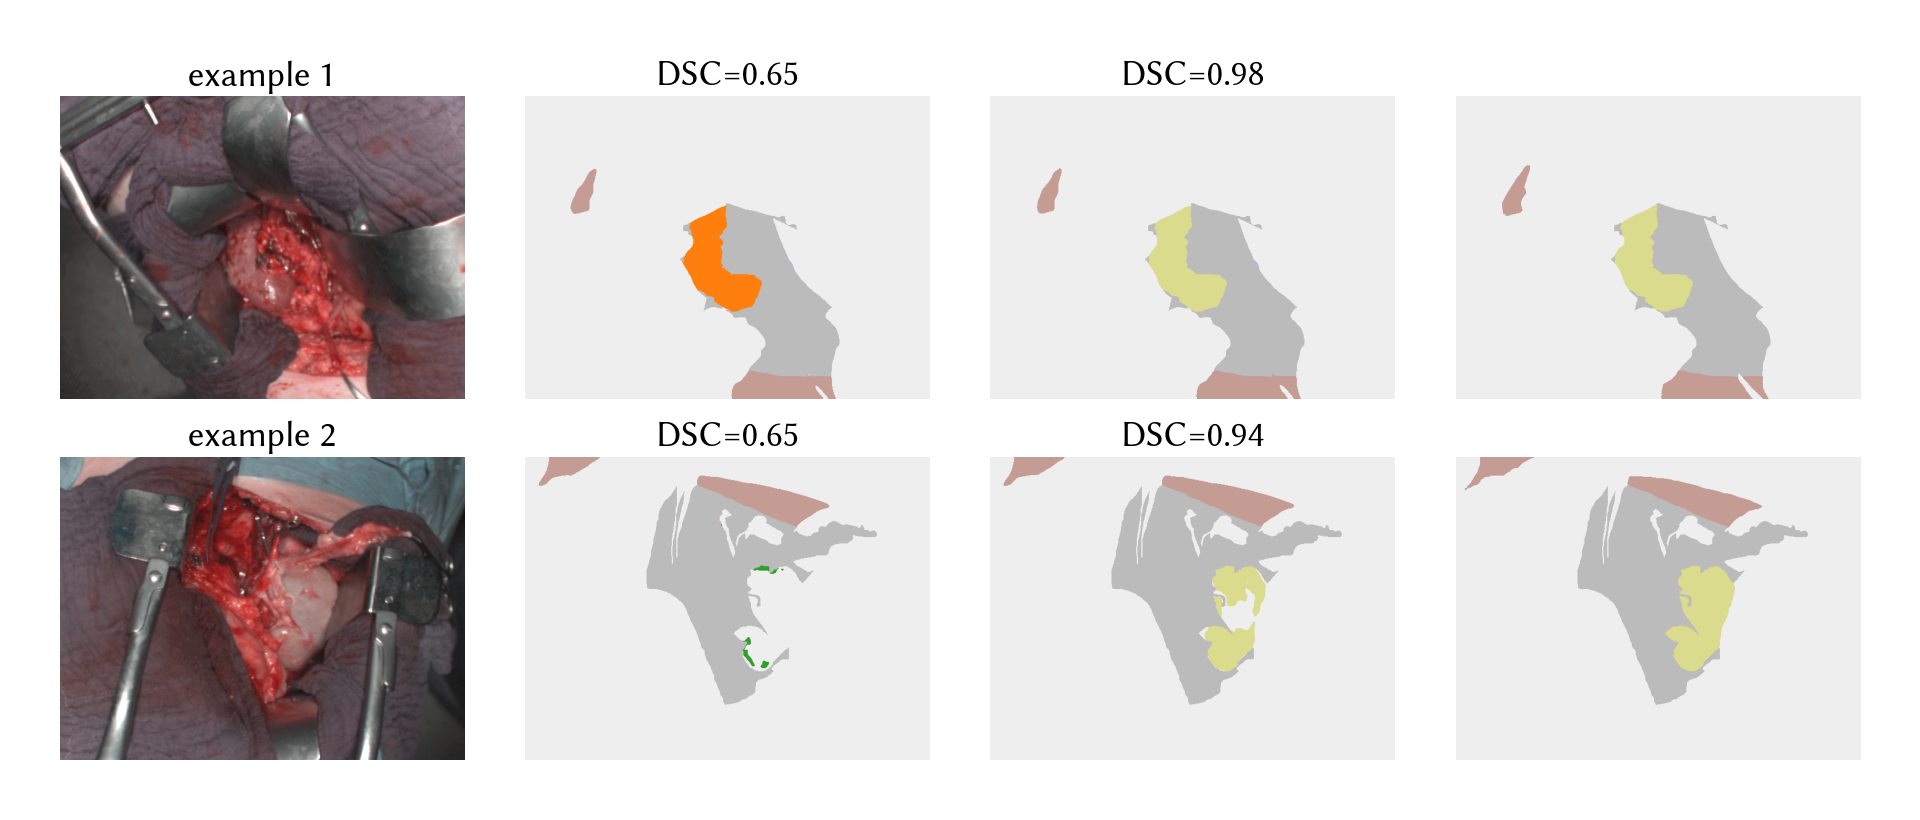

In [2]:
class PredictionComparison:
    def __init__(self, target_species: str, source_species: str):
        self.target_species = target_species
        self.source_species = source_species

        self.model_name = "image"
        self.run_folder_baseline = f"{settings_species.model_timestamp}_baseline_{self.target_species}_nested-*-2"
        self.run_folder_projected = f"{settings_species.model_timestamp}_projected-malperfusion_{self.source_species}2{self.target_species}_nested-*-2"

        self._load_scores()
        self.baseline_predictor = SinglePredictor(model=self.model_name, run_folder=self.run_folder_baseline, test=True)
        self.projected_predictor = SinglePredictor(
            model=self.model_name, run_folder=self.run_folder_projected, test=True
        )

        self.label_mapping = settings_species.label_mapping
        self.label_mapping.label_colors = settings_seg.label_colors_paper

    def _load_scores(self) -> None:
        df_baseline = pd.concat([
            load_nested_table(run_folder=self.run_folder_baseline, table_name=f"test_table_{self.target_species}"),
            load_nested_table(
                run_folder=self.run_folder_baseline, table_name=f"test_table_{self.target_species}_perfusion"
            ),
        ])
        df_baseline["network"] = "in-species"

        df_projected = pd.concat([
            load_nested_table(run_folder=self.run_folder_projected, table_name=f"test_table_{self.target_species}"),
            load_nested_table(
                run_folder=self.run_folder_projected, table_name=f"test_table_{self.target_species}_perfusion"
            ),
        ])
        df_projected["network"] = "xeno-learning"

        df_baseline = df_baseline.query("annotation_name == 'semantic#primary'")
        df_projected = df_projected.query("annotation_name == 'semantic#primary'")

        df_baseline = df_baseline.sort_values(by="image_name", ignore_index=True)
        df_projected = df_projected.sort_values(by="image_name", ignore_index=True)
        assert (df_baseline.image_name.values == df_projected.image_name.values).all()

        df_projected["diff_image"] = df_projected["dice_metric_image"] - df_baseline["dice_metric_image"]
        df_projected = df_projected.sort_values("diff_image", ascending=False)

        self.df_scores_baseline = df_baseline
        self.df_scores_projected = df_projected

        self.df_best_subjects = (
            df_projected.groupby(["subject_name"]).first().sort_values("diff_image", ascending=False)
        )

    def top_baseline_row(self, topk: int = 1) -> pd.DataFrame:
        return self.df_scores_baseline[
            self.df_scores_baseline.image_name == self.top_projected_row(topk=topk).iloc[0].image_name
        ]

    def top_projected_row(self, topk: int = 1) -> pd.DataFrame:
        top_image_name = self.df_best_subjects.iloc[topk - 1].image_name
        return self.df_scores_projected[self.df_scores_projected.image_name == top_image_name]

    def predictions(
        self, path: DataPath = None, topk: int = 1
    ) -> tuple[np.ndarray, np.ndarray | np.ndarray | np.ndarray]:
        if path is None:
            path = DataPath.from_table(self.top_projected_row(topk=topk))[0]

        sample = DatasetImage([path], train=False, config=self.baseline_predictor.config)[0]

        res_baseline = self.baseline_predictor.predict_sample(sample["features"])["class"].cpu().argmax(dim=0)
        res_baseline[~sample["valid_pixels"]] = settings.label_index_thresh
        seg_baseline = map_label_image(res_baseline, self.label_mapping)

        res_projected = self.projected_predictor.predict_sample(sample["features"])["class"].cpu().argmax(dim=0)
        res_projected[~sample["valid_pixels"]] = settings.label_index_thresh
        seg_projected = map_label_image(res_projected, self.label_mapping)

        seg_reference = map_label_image(sample["labels"], self.label_mapping)

        return path.read_rgb_reconstructed(), seg_baseline, seg_projected, seg_reference


seed_everything(42)
n_top = 2
fig, axes = plt.subplots(n_top, 4, figsize=(3, n_top), dpi=600)
fig.subplots_adjust(hspace=-0.57, wspace=0.15, left=0, right=1, bottom=0, top=1)

source_species = "pig"
target_species = "human"
predictor = PredictionComparison(target_species, source_species)

fontsize = 4.3
y_offset = 0.87

for i in range(n_top):
    rgb, seg_baseline, seg_projected, seg_reference = predictor.predictions(topk=i + 1)
    print(predictor.top_baseline_row(topk=i + 1)["image_name"])

    axes[i, 0].imshow(rgb, origin="lower")
    axes[i, 0].set_title(f"example {i + 1}", fontsize=fontsize, y=y_offset)
    axes[i, 0].axis("off")

    axes[i, 1].imshow(seg_baseline, origin="lower")
    axes[i, 1].axis("off")
    axes[i, 1].set_title(
        f"DSC={predictor.top_baseline_row(topk=i + 1).iloc[0]['dice_metric_image']:.02f}",
        fontsize=fontsize,
        y=y_offset,
    )

    axes[i, 2].imshow(seg_projected, origin="lower")
    axes[i, 2].axis("off")
    axes[i, 2].set_title(
        f"DSC={predictor.top_projected_row(topk=i + 1).iloc[0]['dice_metric_image']:.02f}",
        fontsize=fontsize,
        y=y_offset,
    )

    axes[i, 3].imshow(seg_reference, origin="lower")
    axes[i, 3].axis("off")

for ax in axes.flatten():
    ax.invert_yaxis()

fig.savefig(settings_species.paper_dir / "image_examples_predictions.pdf", dpi=1200, bbox_inches="tight")

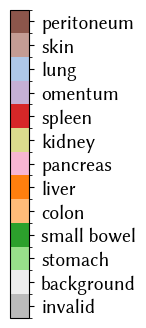

In [3]:
label_colors = {"invalid": predictor.label_mapping.name_to_color("invalid")}
label_colors |= {label: predictor.label_mapping.name_to_color(label) for label in predictor.label_mapping.label_names()}

# Colorbar based on the label names/colors
cmap = mpl.colors.ListedColormap(list(label_colors.values()))
bounds = list(range(len(label_colors)))
bounds.append(max(bounds) + 1)
norm = mpl.colors.BoundaryNorm(bounds, cmap.N)

fig, ax = plt.subplots(figsize=(0.25, 4), dpi=100)
cbar = fig.colorbar(mpl.cm.ScalarMappable(norm=norm, cmap=cmap), cax=ax)

tick_names = [settings_rat.labels_paper_renaming.get(l, l) for l in label_colors.keys()]
tick_names = [l.replace("<br>", "\n") for l in tick_names]

# We want the ticks to be placed in the middle of the box
r = cbar.vmax - cbar.vmin
cbar.set_ticks([cbar.vmin + r / len(tick_names) * (0.5 + i) for i in range(len(tick_names))])
cbar.ax.set_yticklabels(tick_names)
cbar.ax.tick_params(pad=5)

fig.savefig(settings_species.paper_dir / "image_examples_cbar.pdf", bbox_inches="tight")